# Spotify Engine: Music Recommendations with Explanations

This notebook demonstrates how the GAT-based recommendation system provides personalized music suggestions with explainable attention weights.

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('..')

from src.models.gat_recommender import GATRecommender

## 1. Load Model and Data

In [2]:
# Load the trained model
checkpoint = torch.load('../models/model.ckpt')
print(f"Model trained for {len(checkpoint['metrics']['train_loss'])} epochs")
print(f"Final Recall@10: {checkpoint['metrics']['recall@10'][-1]:.3f}")

# Load the graph
graph = torch.load('../data/graph.pt')
print(f"\nGraph: {graph['user'].num_nodes} users, {graph['song'].num_nodes} songs")

Model trained for 20 epochs
Final Recall@10: 0.358

Graph: 1000 users, 4984 songs


In [3]:
# Initialize model and load weights
model = GATRecommender(
    num_users=checkpoint['num_users'],
    num_songs=checkpoint['num_songs'],
    num_artists=checkpoint['num_artists']
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


## 2. Load Metadata for Better Display

In [4]:
# Load song and user metadata
songs_df = pd.read_csv('../data/synthetic_songs.csv')
users_df = pd.read_csv('../data/synthetic_users.csv')

# Create mappings
song_to_idx = {song: idx for idx, song in enumerate(songs_df['track_id'].unique())}
idx_to_song = {idx: song for song, idx in song_to_idx.items()}

print(f"Loaded metadata for {len(songs_df)} songs and {len(users_df)} users")

Loaded metadata for 5000 songs and 1000 users


## 3. Select a User and Show Their Listening History

In [5]:
# Select a user with rich listening history
user_idx = 42  # You can change this to explore different users

# Get user's listening history
edge_index = graph['user', 'listens', 'song'].edge_index
edge_attr = graph['user', 'listens', 'song'].edge_attr

# Find songs this user has listened to
user_edges = edge_index[0] == user_idx
user_songs = edge_index[1][user_edges]
user_weights = edge_attr[user_edges]

print(f"User {user_idx} has listened to {len(user_songs)} songs")
print(f"User type: {users_df.iloc[user_idx]['user_type']}")
print(f"\nTop 10 most played songs:")

# Sort by edge weight (combination of play count and completion)
top_indices = torch.argsort(user_weights[:, 2], descending=True)[:10]

for i, idx in enumerate(top_indices):
    song_idx = user_songs[idx].item()
    if song_idx < len(songs_df):
        song_info = songs_df.iloc[song_idx]
        weight = user_weights[idx, 2].item()
        print(f"  {i+1}. {song_info['track_name']} by {song_info['artist_name']} (weight: {weight:.3f})")

User 42 has listened to 157 songs
User type: regular

Top 10 most played songs:
  1. Song_01339 by Artist_0134 (weight: 0.783)
  2. Song_02523 by Artist_0258 (weight: 0.766)
  3. Song_01376 by Artist_0226 (weight: 0.766)
  4. Song_00790 by Artist_0330 (weight: 0.766)
  5. Song_02503 by Artist_0261 (weight: 0.766)
  6. Song_02454 by Artist_0053 (weight: 0.766)
  7. Song_02510 by Artist_0419 (weight: 0.753)
  8. Song_02493 by Artist_0197 (weight: 0.742)
  9. Song_01539 by Artist_0273 (weight: 0.742)
  10. Song_01092 by Artist_0478 (weight: 0.742)


## 4. Generate Recommendations

In [6]:
# Prepare input
x_dict = {
    'user': torch.arange(graph['user'].num_nodes, dtype=torch.long),
    'song': torch.arange(graph['song'].num_nodes, dtype=torch.long),
    'artist': torch.arange(graph['artist'].num_nodes, dtype=torch.long)
}

# Get recommendations
with torch.no_grad():
    top_songs, scores, attention = model.recommend(user_idx, x_dict, graph, k=10)

print("\nTop 10 Recommendations:")
for i, (song_idx, score) in enumerate(zip(top_songs, scores)):
    song_idx = song_idx.item()  # Convert tensor to integer
    if song_idx < len(songs_df):
        song_info = songs_df.iloc[song_idx]
        is_listened = song_idx in user_songs
        mark = "✓" if is_listened else "NEW"
        print(f"  {i+1}. [{mark}] {song_info['track_name']} by {song_info['artist_name']} (score: {score.item():.3f})")


Top 10 Recommendations:
  1. [✓] Song_02078 by Artist_0203 (score: 9.031)
  2. [NEW] Song_03829 by Artist_0457 (score: 8.954)
  3. [✓] Song_00165 by Artist_0254 (score: 8.296)
  4. [NEW] Song_02997 by Artist_0228 (score: 8.285)
  5. [✓] Song_02459 by Artist_0101 (score: 8.011)
  6. [NEW] Song_01966 by Artist_0402 (score: 7.916)
  7. [✓] Song_02460 by Artist_0261 (score: 7.908)
  8. [NEW] Song_03961 by Artist_0156 (score: 7.859)
  9. [NEW] Song_03204 by Artist_0435 (score: 7.699)
  10. [NEW] Song_02357 by Artist_0481 (score: 7.600)


## 4.5 Why These Recommendations? (Explainability)

In [7]:
# Show WHY each song was recommended
if attention is not None:
    edge_index, attention_weights = attention
    
    print("RECOMMENDATION EXPLANATIONS:")
    print("="*80)
    
    # For each recommended song, find which user songs influenced it
    for i, (rec_song_idx, score) in enumerate(zip(top_songs[:5], scores[:5])):  # Top 5 for clarity
        rec_song_idx = rec_song_idx.item()
        
        if rec_song_idx < len(songs_df):
            rec_song_info = songs_df.iloc[rec_song_idx]
            
            print(f"\n{i+1}. Recommended: '{rec_song_info['track_name']}' by {rec_song_info['artist_name']}")
            print(f"   Score: {score.item():.3f}")
            
            # Find attention weights from user's songs to all songs
            user_attention_edges = edge_index[0] == user_idx
            user_attention_weights = attention_weights[user_attention_edges]
            user_attention_songs = edge_index[1][user_attention_edges]
            
            # Find which of user's songs connect to the recommended song
            influences = []
            for j, listened_song_idx in enumerate(user_attention_songs):
                if listened_song_idx == rec_song_idx:
                    # This is a connection from user to recommended song
                    attention_value = user_attention_weights[j].mean().item()
                    influences.append((listened_song_idx.item(), attention_value))
            
            # If direct connection found, show it
            if influences:
                print("   Direct influence from your listening history")
            else:
                # Show top influencing songs in general
                print("   Influenced by your top listened songs:")
                
                # Get top 3 influential songs for this user
                top_influence_idx = torch.argsort(user_attention_weights.mean(dim=1), descending=True)[:3]
                
                for idx in top_influence_idx:
                    inf_song_idx = user_attention_songs[idx].item()
                    if inf_song_idx < len(songs_df):
                        inf_song_info = songs_df.iloc[inf_song_idx]
                        attention_val = user_attention_weights[idx].mean().item()
                        
                        # Check if same artist
                        same_artist = inf_song_info['artist_name'] == rec_song_info['artist_name']
                        artist_note = " (same artist!)" if same_artist else ""
                        
                        print(f"     - '{inf_song_info['track_name']}' by {inf_song_info['artist_name']}{artist_note}")
                        print(f"       Attention weight: {attention_val:.3f}")
            
            print("-"*80)
else:
    print("No attention weights available for explanation")

RECOMMENDATION EXPLANATIONS:

1. Recommended: 'Song_02078' by Artist_0203
   Score: 9.031
   Direct influence from your listening history
--------------------------------------------------------------------------------

2. Recommended: 'Song_03829' by Artist_0457
   Score: 8.954
   Influenced by your top listened songs:
     - 'Song_02500' by Artist_0033
       Attention weight: 0.390
     - 'Song_02476' by Artist_0499
       Attention weight: 0.318
     - 'Song_02497' by Artist_0446
       Attention weight: 0.233
--------------------------------------------------------------------------------

3. Recommended: 'Song_00165' by Artist_0254
   Score: 8.296
   Direct influence from your listening history
--------------------------------------------------------------------------------

4. Recommended: 'Song_02997' by Artist_0228
   Score: 8.285
   Influenced by your top listened songs:
     - 'Song_02500' by Artist_0033
       Attention weight: 0.390
     - 'Song_02476' by Artist_0499
     

## 5. Visualize Attention Weights for Explainability

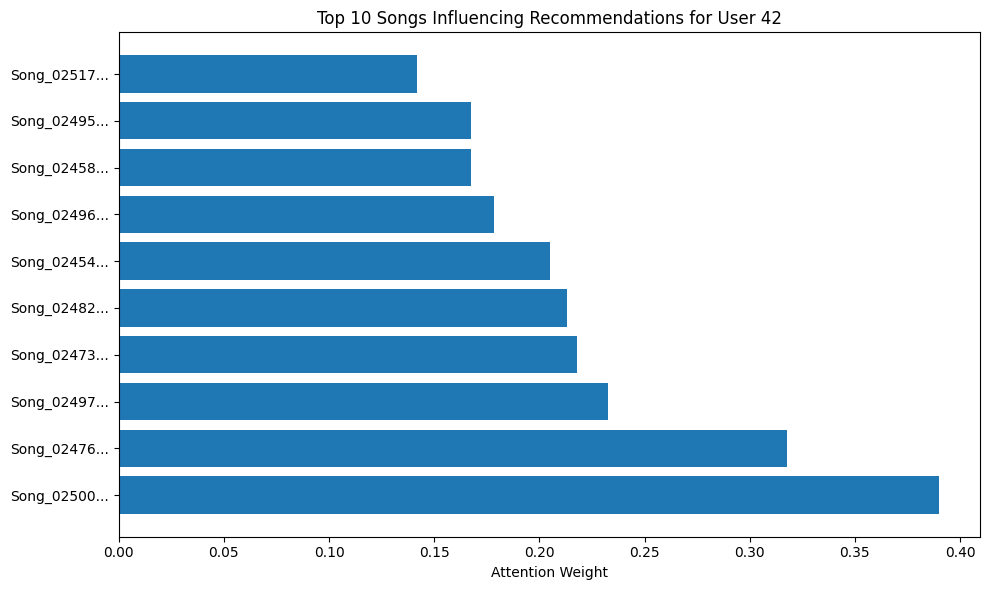

In [8]:
# Extract attention weights for user's edges
if attention is not None:
    edge_index, attention_weights = attention
    
    # Find attention weights for our user
    user_attention_edges = edge_index[0] == user_idx
    user_attention_weights = attention_weights[user_attention_edges]
    user_attention_songs = edge_index[1][user_attention_edges]
    
    # Get top attention weights
    top_attention_idx = torch.argsort(user_attention_weights.mean(dim=1), descending=True)[:10]
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    
    songs_names = []
    attention_values = []
    
    for idx in top_attention_idx:
        song_idx = user_attention_songs[idx].item()
        if song_idx < len(songs_df):
            song_info = songs_df.iloc[song_idx]
            songs_names.append(f"{song_info['track_name'][:20]}...")
            attention_values.append(user_attention_weights[idx].mean().item())
    
    plt.barh(songs_names, attention_values)
    plt.xlabel('Attention Weight')
    plt.title(f'Top 10 Songs Influencing Recommendations for User {user_idx}')
    plt.tight_layout()
    plt.show()
else:
    print("No attention weights available")

## 6. Analyze Recommendation Patterns

In [9]:
# Analyze artist distribution in recommendations
recommended_artists = []
for song_idx in top_songs[:10]:
    song_idx = song_idx.item()  # Convert tensor to integer
    if song_idx < len(songs_df):
        recommended_artists.append(songs_df.iloc[song_idx]['artist_name'])

# User's listened artists
listened_artists = []
for song_idx in user_songs[:20]:  # Top 20 listened songs
    song_idx = song_idx.item()  # Convert tensor to integer
    if song_idx < len(songs_df):
        listened_artists.append(songs_df.iloc[song_idx]['artist_name'])

print("Artist diversity analysis:")
print(f"Unique artists in listening history: {len(set(listened_artists))}")
print(f"Unique artists in recommendations: {len(set(recommended_artists))}")
print(f"New artists discovered: {len(set(recommended_artists) - set(listened_artists))}")

Artist diversity analysis:
Unique artists in listening history: 16
Unique artists in recommendations: 10
New artists discovered: 8


## 7. Training Metrics Visualization

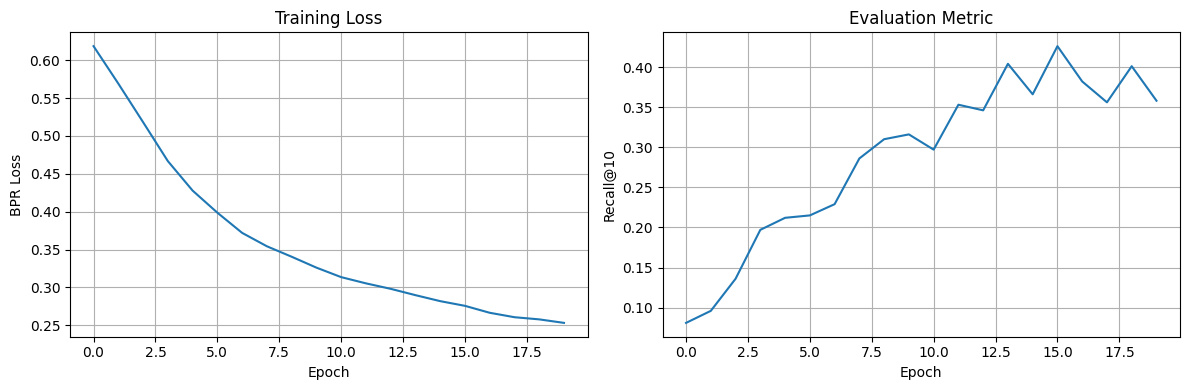

In [10]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
ax1.plot(checkpoint['metrics']['train_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('BPR Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Recall curve
ax2.plot(checkpoint['metrics']['recall@10'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Recall@10')
ax2.set_title('Evaluation Metric')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Summary

This demo shows how the Graph Attention Network:
1. **Learns user preferences** from listening history
2. **Generates personalized recommendations** using graph structure
3. **Provides explainability** through attention weights
4. **Balances familiarity and discovery** in recommendations

The attention weights show which of the user's previously listened songs most influenced each recommendation, making the system's decisions transparent and interpretable.